<a href="https://colab.research.google.com/github/souvik25162/ArimaAnnHybrid/blob/master/Bayesian_Sarima%2Blstm_sweden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step1:

#Update pymc3

In [1]:
!pip install pymc3==3.8

In [2]:
!pip install arviz==0.6.1

#Required Packages for Arima &Sarima

In [3]:
%matplotlib inline
import theano
import theano.tensor as tt
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
plt.style.use('seaborn')
register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Sweden Unempoyment dataset

In [6]:
from google.colab import files
uploaded=files.upload()
df=pd.read_csv('sweden.csv')
df.rename(columns={'LRHUTTTTSEM156S':'values'},inplace=True)
print(df.shape)

Saving sweden.csv to sweden (1).csv
(432, 2)


In [7]:
df.head()

,DATE,values
0,1983-01-01,3.4
1,1983-02-01,3.7
2,1983-03-01,3.7
3,1983-04-01,3.4
4,1983-05-01,3.7


In [8]:
df.index= pd.to_datetime(df.pop('DATE'))

In [9]:
training_datalen=len(df)-36

In [10]:
ts=df.values
train=ts[0:training_datalen]
test= ts[training_datalen:len(ts)]

In [11]:
df.head()

,values
DATE,
1983-01-01,3.4
1983-02-01,3.7
1983-03-01,3.7
1983-04-01,3.4
1983-05-01,3.7


In [12]:
inf=df

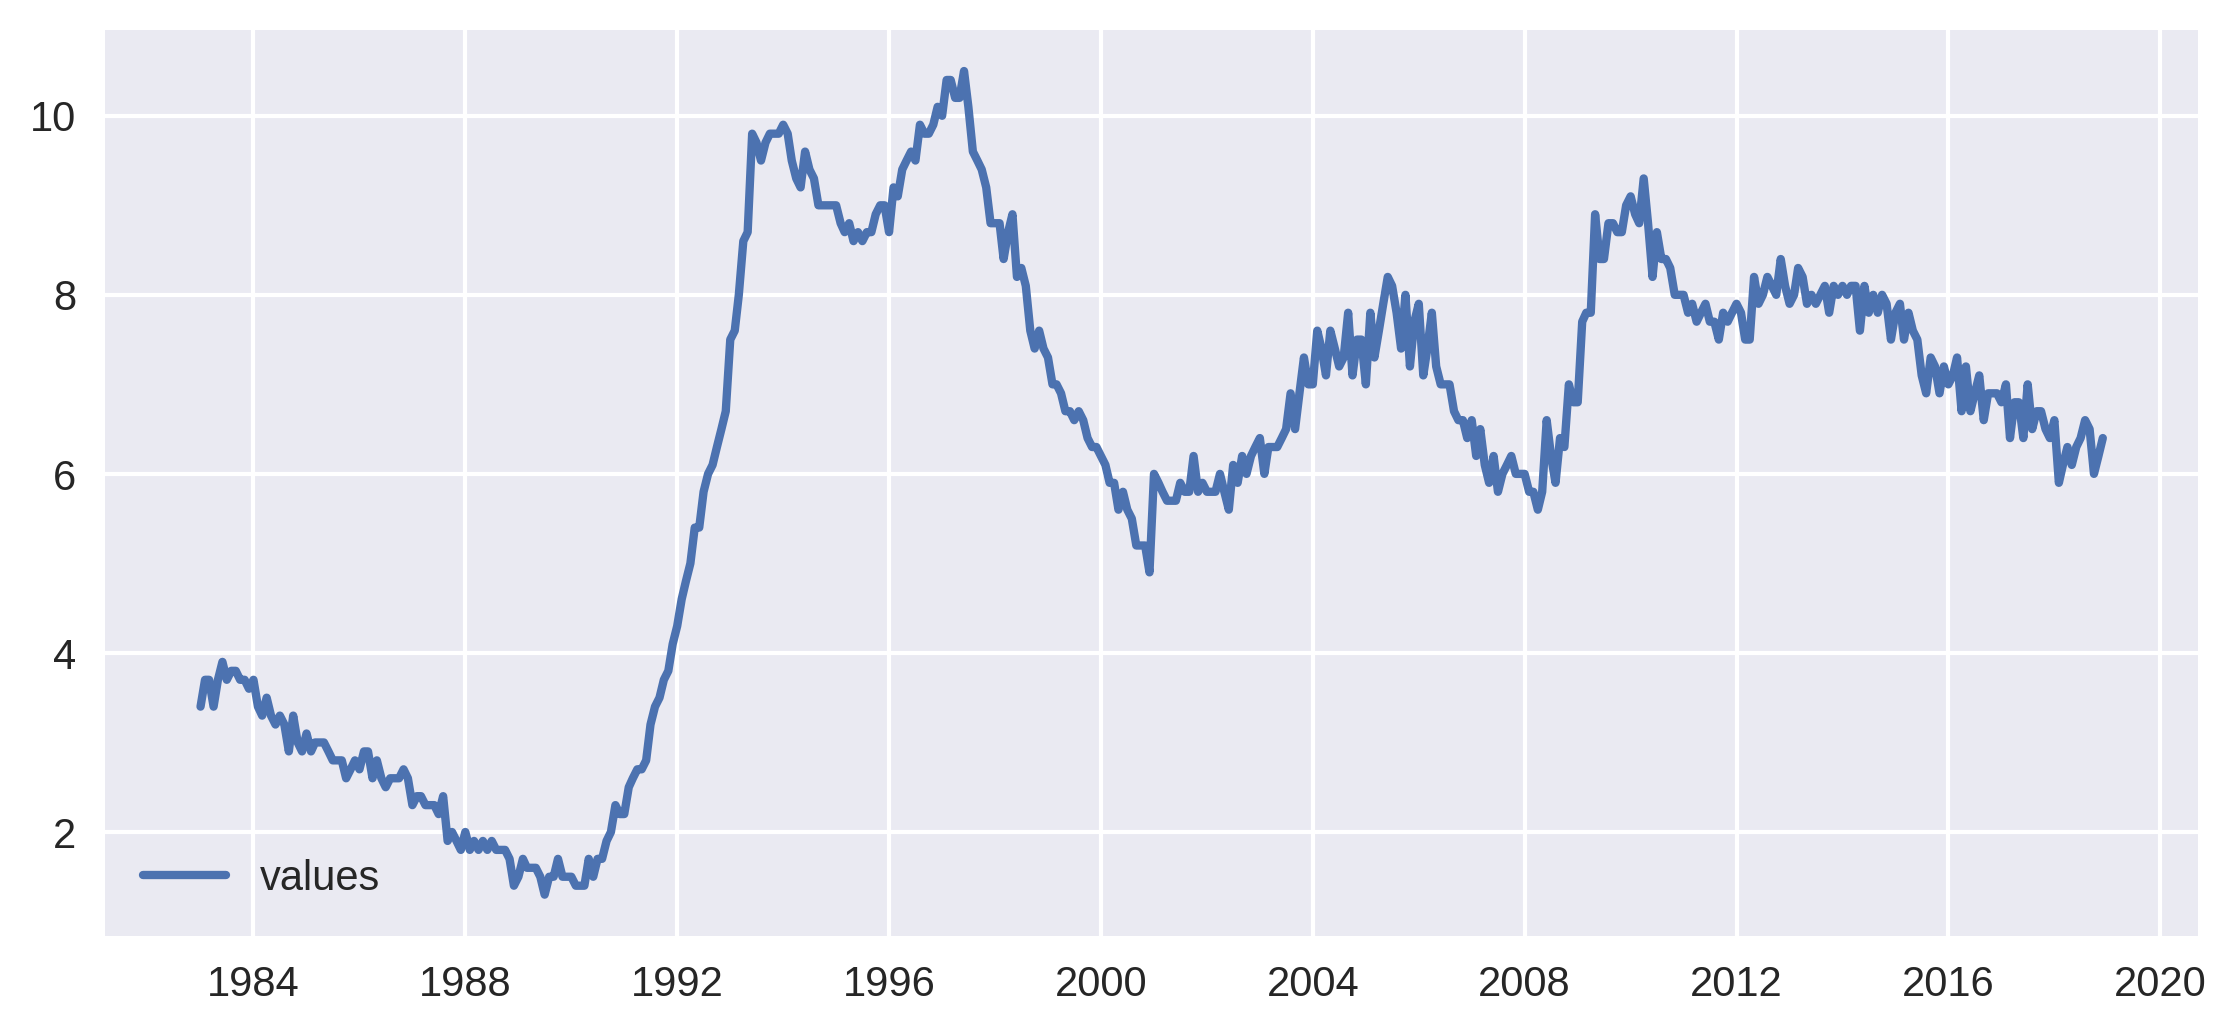

In [13]:
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)
ax.plot(inf.index, inf, label=r'values', lw=2)
ax.legend(loc='lower left')
plt.show()

#Basic Sarima Model with p=2 & q=1

In [95]:
mod = sm.tsa.statespace.SARIMAX(inf, order=(2, 0, 1))

res_mle = mod.fit(disp=False)
print(res_mle.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                           Statespace Model Results                           
Dep. Variable:                 values   No. Observations:                  432
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 -64.849
Date:                Fri, 15 Jan 2021   AIC                            137.699
Time:                        12:36:27   BIC                            153.972
Sample:                    01-01-1983   HQIC                           144.123
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0188      0.019      1.003      0.316      -0.018       0.056
ar.L2          0.9788      0.019     52.432      0.000       0.942       1.015
ma.L1          0.9952      0.011     87.314      0.0

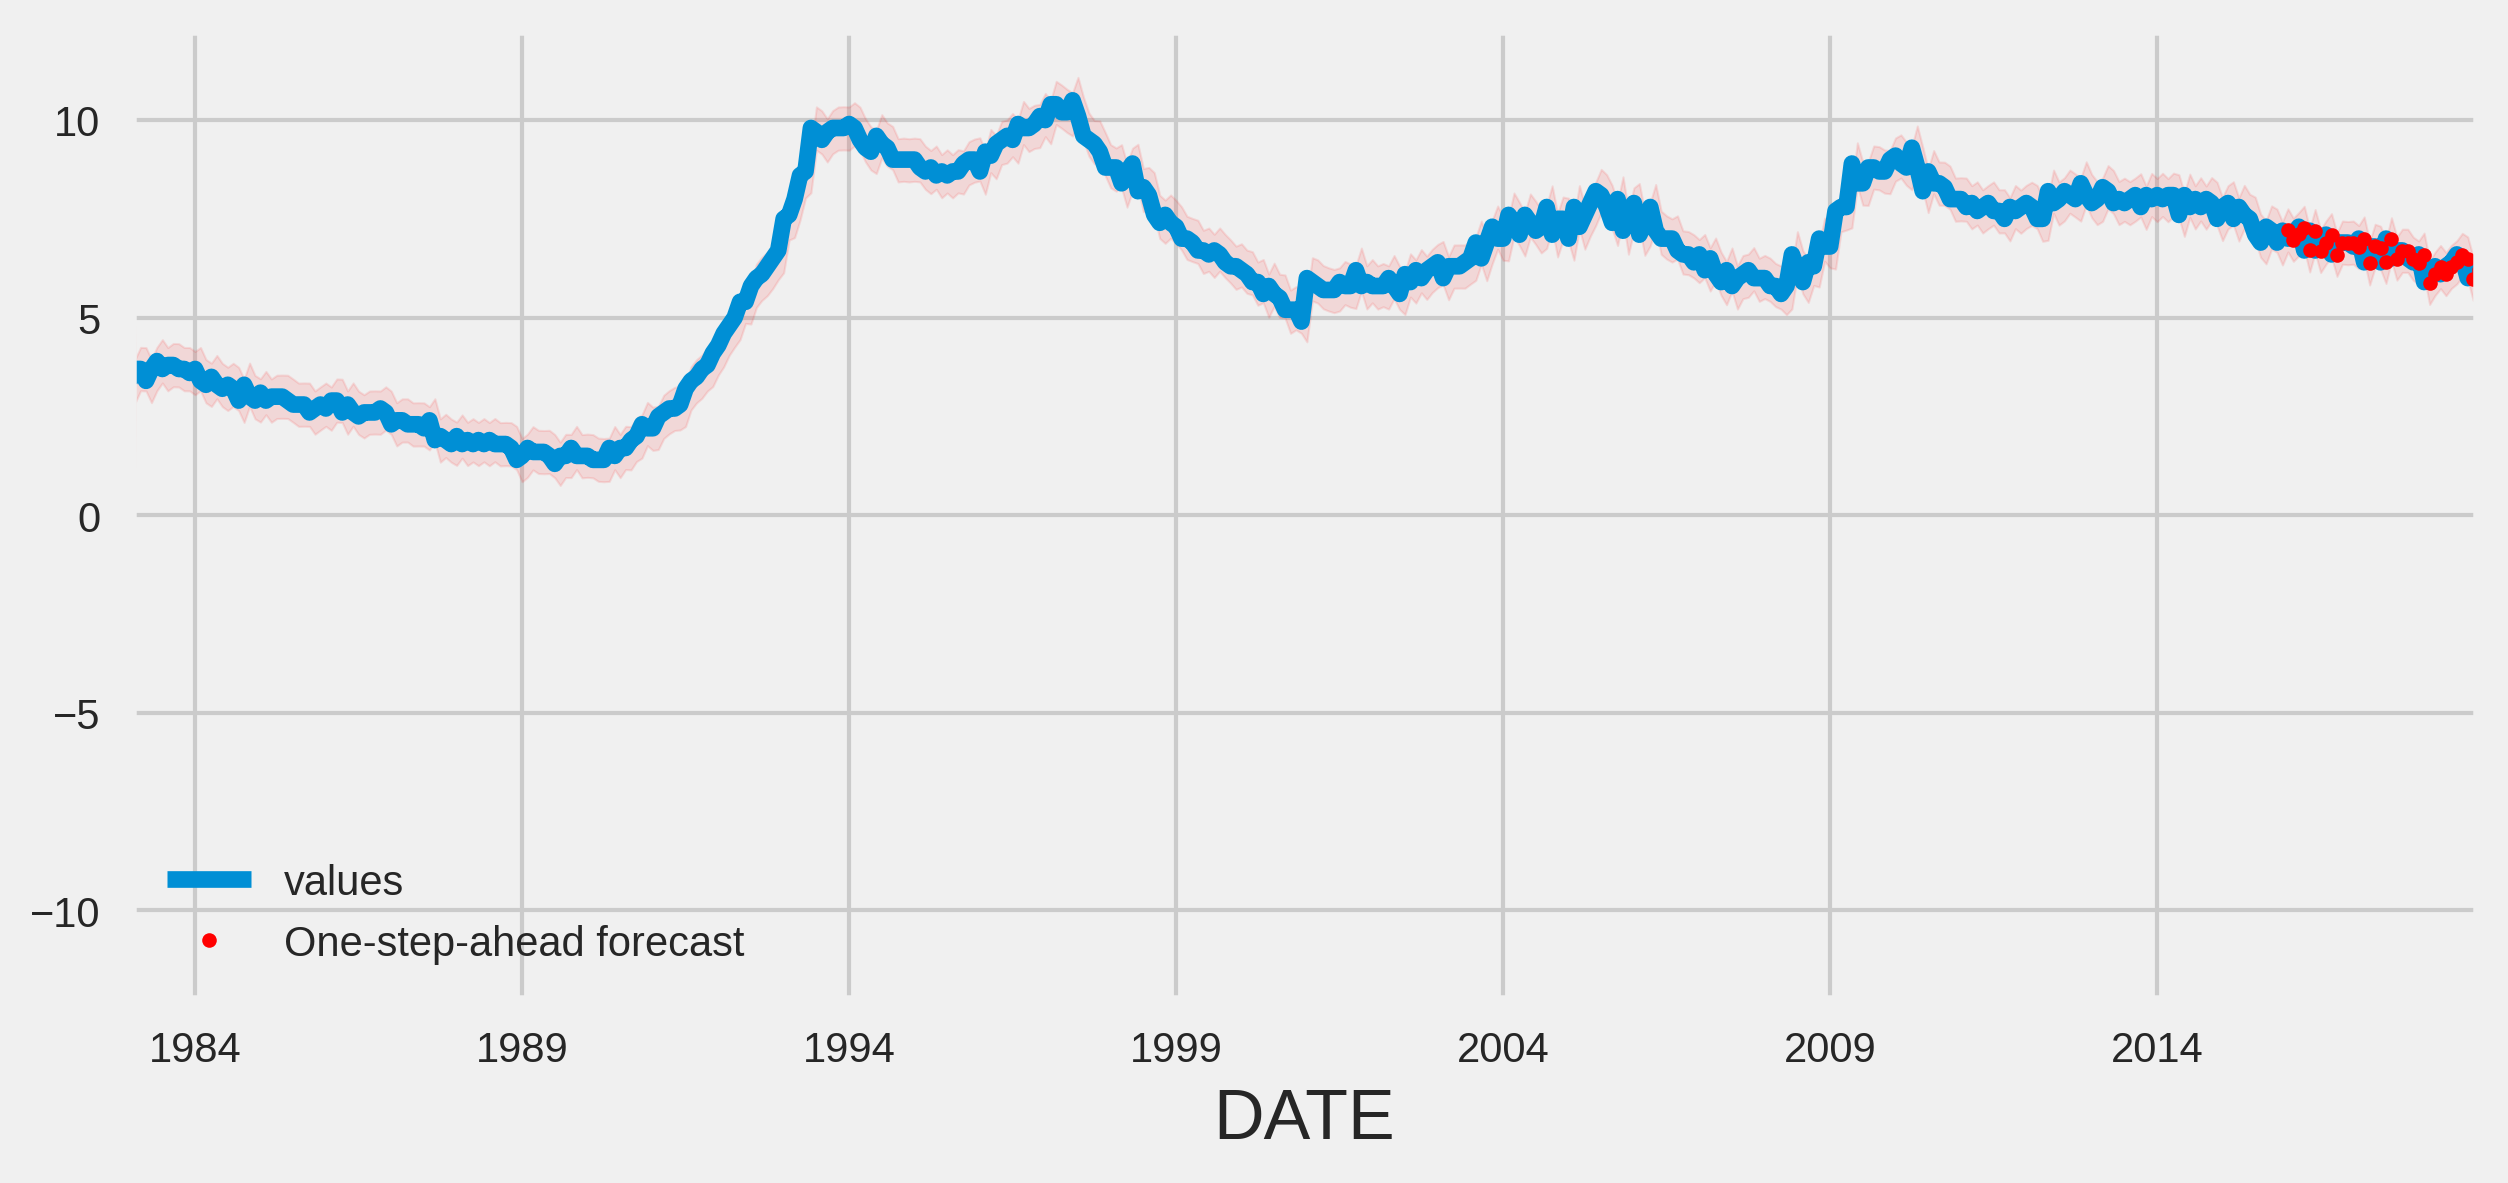

In [96]:
predict_mle = res_mle.get_prediction()
predict_mle_ci = predict_mle.conf_int()
lower = predict_mle_ci['lower values']
upper = predict_mle_ci['upper values']

# Graph
fig, ax = plt.subplots(figsize=(9,4), dpi=300)
# Plot data points
inf.plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict_mle.predicted_mean[training_datalen:len(ts)].plot(ax=ax, style='r.', label='One-step-ahead forecast')
ax.fill_between(predict_mle_ci.index, lower, upper, color='r', alpha=0.1)
ax.legend(loc='lower left')
plt.show()


In [97]:
output= predict_mle.predicted_mean

In [98]:
pred= output[training_datalen:len(output)]

In [18]:
pred

2016-01-01    7.208540
2016-02-01    6.971395
2016-03-01    7.113014
2016-04-01    7.272751
2016-05-01    6.701201
2016-06-01    7.189644
2016-07-01    6.686022
2016-08-01    6.900574
2016-09-01    7.085612
2016-10-01    6.590274
2016-11-01    6.897976
2016-12-01    6.885413
2017-01-01    6.897914
2017-02-01    6.784082
2017-03-01    7.002265
2017-04-01    6.372548
2017-05-01    6.817490
2017-06-01    6.766235
2017-07-01    6.411668
2017-08-01    6.981349
2017-09-01    6.494754
2017-10-01    6.692368
2017-11-01    6.691475
2017-12-01    6.489577
2018-01-01    6.393340
2018-02-01    6.594016
2018-03-01    5.880322
2018-04-01    6.108174
2018-05-01    6.279977
2018-06-01    6.101981
2018-07-01    6.286140
2018-08-01    6.400029
2018-09-01    6.587361
2018-10-01    6.495304
2018-11-01    5.982065
2018-12-01    6.206200
Freq: MS, dtype: float64

In [99]:
test= ts[training_datalen:len(ts)]

In [100]:
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test,pred)
print("MSE:",error)

print("RMSE:",np.sqrt(error))

MSE: 0.10560789309447388
RMSE: 0.3249736806180985


In [101]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,pred)
print("MAE:",error)

MAE: 0.26666591255799427


#BAYESIAN Sarima


In [22]:
inf = df
#inf is the series we will use for analysis
print(inf.head())

            values
DATE              
1983-01-01     3.4
1983-02-01     3.7
1983-03-01     3.7
1983-04-01     3.4
1983-05-01     3.7


In [23]:
mod = sm.tsa.statespace.SARIMAX(inf, order=(1, 0, 1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [24]:
class Loglike(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        theta, = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out


class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        theta, = inputs
        outputs[0][0] = self.model.score(theta)

In [25]:
# Set sampling params
ndraws = 6000  # number of draws from the distribution
nburn = 1000  # number of "burn-in points" (which will be discarded)

In [26]:
loglike = Loglike(mod)

In [27]:
with pm.Model():
    # Priors
    arL1 = pm.Uniform('ar.L1', -1, 1)
    maL1 = pm.Uniform('ma.L1', -1, 1)
    sigma2 = pm.InverseGamma('sigma2', 2, 4)

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([arL1, maL1, sigma2])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: loglike(v), observed={'v': theta})

    # Draw samples
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma2, ma.L1, ar.L1]
Sampling chain 1, 38 divergences: 100%|██████████| 7000/7000 [03:15<00:00, 35.78it/s]
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

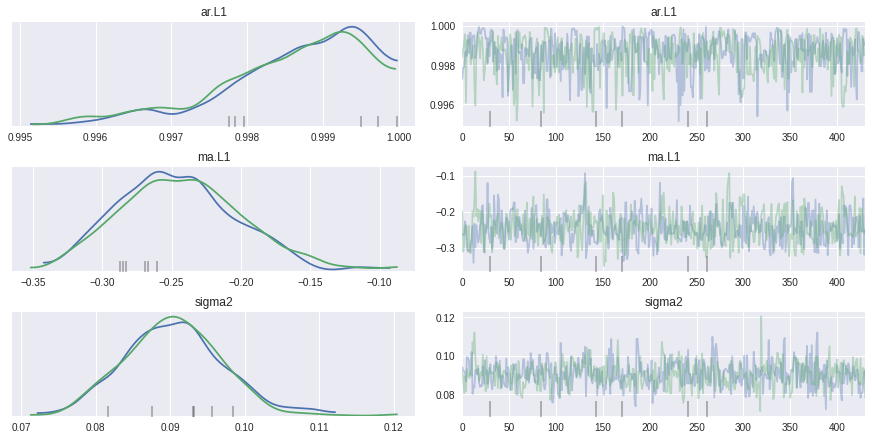

In [28]:
import arviz as az
axes = az.plot_trace(trace[0:len(ts)-1])
fig = axes.ravel()[0].figure

The NUTS sampler is auto-assigned because we provided gradients. PyMC3 will use Metropolis or Slicing samplers if it does not find that gradients are available. There are an impressive number of draws per second for a “block box” style computation! However, note that if the model can be represented directly by PyMC3 (like the AR(p) models mentioned above), then computation can be substantially faster.

Inference is complete, but are the results any good? There are a number of ways to check. The first is to look at the posterior distributions (with lines showing the MLE values):

/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b409626d8>,
      dtype=object)

<Figure size 576x396 with 0 Axes>

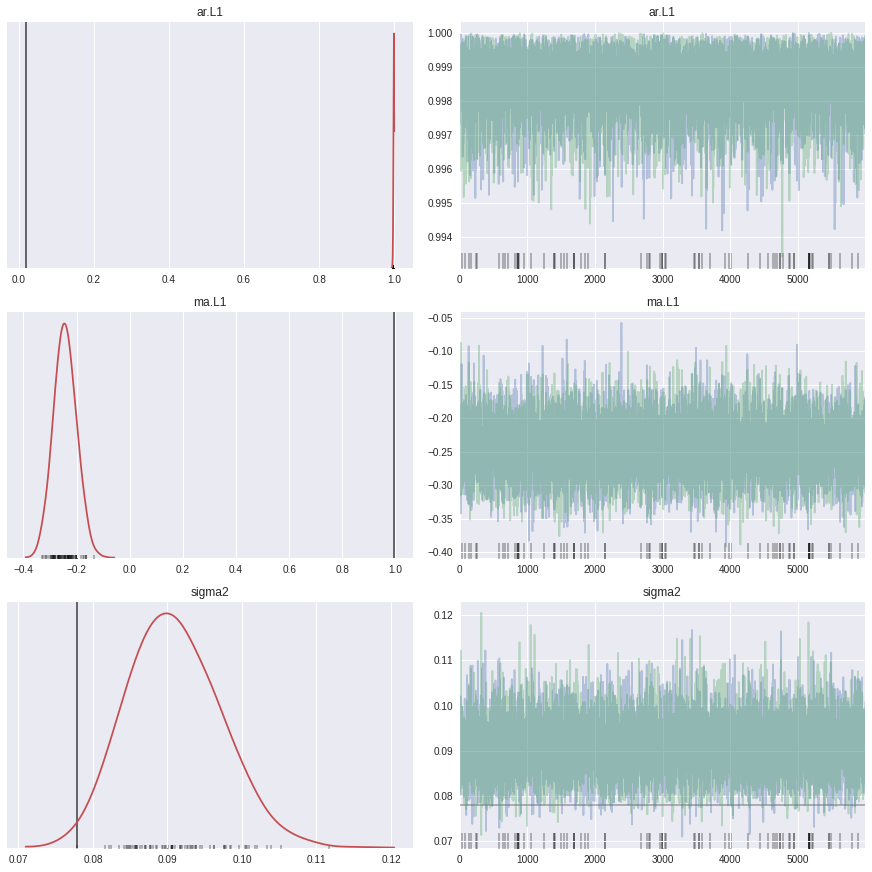

In [29]:
plt.tight_layout()
pm.traceplot(trace,
                 lines=[(k, {}, [v]) for k, v in dict(res_mle.params).items()],
                 combined=True,
                 figsize=(12, 12))

In [30]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ar.L1,0.999,0.001,0.997,1.000,0.0,0.0,7418.0,7416.0,5912.0,4635.0,1.0
ma.L1,-0.244,0.043,-0.324,-0.164,0.0,0.0,8028.0,8028.0,8084.0,6330.0,1.0
sigma2,0.091,0.006,0.080,0.103,0.0,0.0,8236.0,8174.0,8311.0,7331.0,1.0


R^  is the Gelman-Rubin statistic. It tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. for all model parameters, we can have some confidence that convergence has been reached if R-hat<1.2



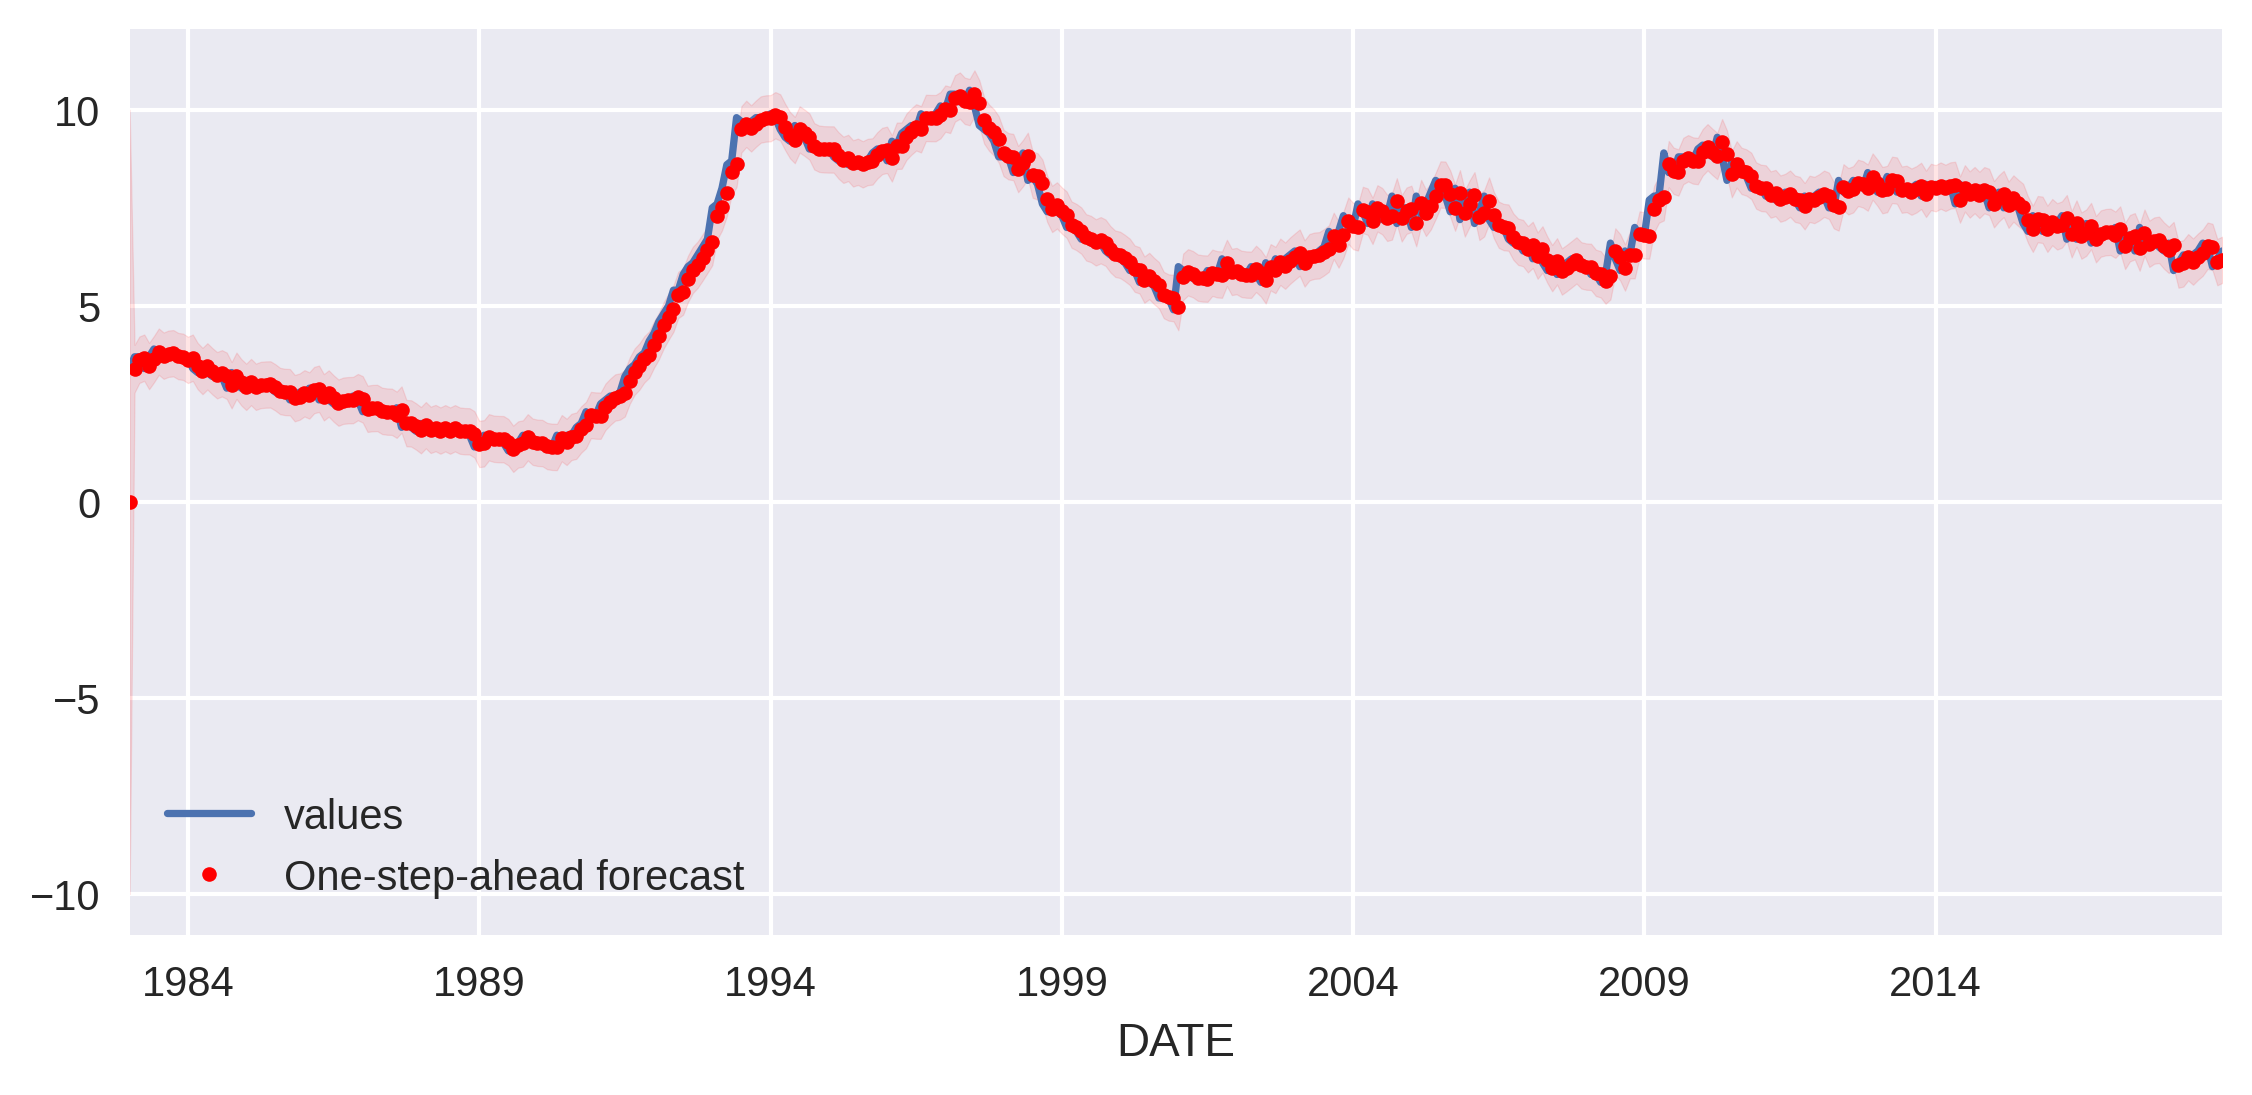

In [31]:
params = pm.summary(trace)['mean'].values

# Construct results using these posterior means as parameter values
res_bayes = mod.smooth(params)

predict_bayes = res_bayes.get_prediction()
predict_bayes_ci = predict_bayes.conf_int()
lower = predict_bayes_ci['lower values']
upper = predict_bayes_ci['upper values']

# Graph
fig, ax = plt.subplots(figsize=(9,4), dpi=300)

# Plot data points
inf.plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict_bayes.predicted_mean.plot(ax=ax, style='r.', label='One-step-ahead forecast')
ax.fill_between(predict_bayes_ci.index, lower, upper, color='r', alpha=0.1)
ax.legend(loc='lower left')
plt.show()

In [32]:
predict_bayes_output = predict_bayes.predicted_mean

In [33]:
pred_bayes=predict_bayes_output[training_datalen:len(predict_bayes_output)]

#Rmse for bayesian model

In [34]:
from sklearn.metrics import mean_squared_error
error2=mean_squared_error(test,pred_bayes)
print("MSE:",error2)

print("RMSE:",np.sqrt(error2))

MSE: 0.0817112469556701
RMSE: 0.28585179194063154


#Lstm

In [35]:
import keras
from keras.layers import Dense,Dropout,LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler,StandardScaler
plt.style.use('fivethirtyeight')
import tensorflow as tf

In [36]:
data=df.filter(['values'])
dataset=data.values
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

In [37]:
train_data= scaled_data[0:training_datalen,:]
time_step=30
test_data= scaled_data[training_datalen-time_step:,:]

In [38]:
training_datalen=len(df)-36

x_train=[]
y_train=[]
for i in range(time_step,len(train_data)):
  x_train.append(train_data[i-time_step:i,0])
  y_train.append(train_data[i,0])
  if i<=time_step:
    print(x_train)
    print(y_train)
    print()

[array([0.22826087, 0.26086957, 0.26086957, 0.22826087, 0.26086957,
       0.2826087 , 0.26086957, 0.27173913, 0.27173913, 0.26086957,
       0.26086957, 0.25      , 0.26086957, 0.22826087, 0.2173913 ,
       0.23913043, 0.2173913 , 0.20652174, 0.2173913 , 0.20652174,
       0.17391304, 0.2173913 , 0.18478261, 0.17391304, 0.19565217,
       0.17391304, 0.18478261, 0.18478261, 0.18478261, 0.17391304])]
[0.16304347826086957]



In [39]:
x_train=np.array(x_train)
y_train=np.array(y_train)

In [40]:
x_train= np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [41]:
print(x_train.shape)

(366, 30, 1)


In [42]:
model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [43]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [78]:
model.fit(x_train,y_train,batch_size=10,epochs=50)

Epoch 1/50
37/37 [==============================] - 1s 25ms/step - loss: 0.0011
Epoch 2/50
37/37 [==============================] - 1s 25ms/step - loss: 9.3270e-04
Epoch 3/50
37/37 [==============================] - 1s 25ms/step - loss: 8.7801e-04
Epoch 4/50
37/37 [==============================] - 1s 26ms/step - loss: 8.2951e-04
Epoch 5/50
37/37 [==============================] - 1s 24ms/step - loss: 8.3874e-04
Epoch 6/50
37/37 [==============================] - 1s 25ms/step - loss: 9.8543e-04
Epoch 7/50
37/37 [==============================] - 1s 25ms/step - loss: 8.7302e-04
Epoch 8/50
37/37 [==============================] - 1s 25ms/step - loss: 8.4203e-04
Epoch 9/50
37/37 [==============================] - 1s 26ms/step - loss: 7.9061e-04
Epoch 10/50
37/37 [==============================] - 1s 25ms/step - loss: 7.6459e-04
Epoch 11/50
37/37 [==============================] - 1s 26ms/step - loss: 7.9192e-04
Epoch 12/50
37/37 [==============================] - 1s 25ms/step - loss: 7.97

In [79]:
x_test=[]
y_test= dataset[training_datalen:,:]
for i in range(time_step,len(test_data)):
  x_test.append(test_data[i-time_step:i,0])

In [80]:
x_test=np.array(x_test)

In [82]:
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [84]:
pred= model.predict(x_test)
pred1=scaler.inverse_transform(pred)

In [85]:
train= data[:training_datalen]
valid=data[training_datalen:]
valid['pred1']=pred1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


No handles with labels found to put in legend.


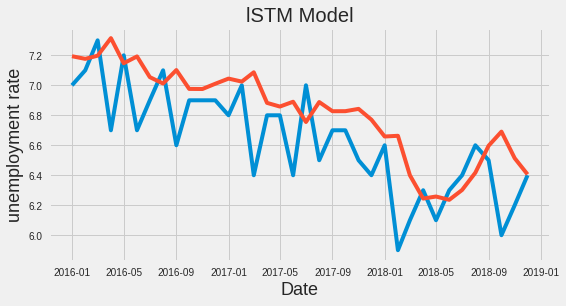

In [86]:
plt.figure(figsize=(8,4))
plt.title("lSTM Model")
plt.xlabel("Date",fontsize=18)
plt.ylabel("unemployment rate",fontsize=18)
plt.plot(valid[['values','pred1']])
plt.legend()
plt.show()

Rmse for LSTM
(can give different results when you run the model multiple times)


In [87]:
from sklearn.metrics import mean_squared_error
error3=mean_squared_error(test,pred1)
print("MSE:",error3)

print("RMSE:",np.sqrt(error3))

MSE: 0.10002809148543665
RMSE: 0.31627217943637825


In [88]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,pred1)
print("MAE:",error)

MAE: 0.23651278548770474


for Bayesian Sarima

In [53]:
from sklearn.metrics import mean_squared_error
error2=mean_squared_error(test,pred_bayes)
print("MSE:",error2)

print("RMSE:",np.sqrt(error2))

MSE: 0.0817112469556701
RMSE: 0.28585179194063154


In [54]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,pred_bayes)
print("MAE:",error)

MAE: 0.23171269327494207


#Hybridization(Bayesian Sarima +Lstm)

In [89]:
NEW_PREDICTION= (pred1.T+pred_bayes.values)/2

In [90]:
NEW_PREDICTION= np.array(NEW_PREDICTION)

In [91]:
NEW_PREDICTION

array([[7.16478088, 7.10122028, 7.13622644, 7.27624844, 6.98587297,
        7.14690643, 6.92280559, 6.93912958, 7.06881496, 6.83784623,
        6.9097908 , 6.94492832, 6.96640638, 6.91969576, 7.01727814,
        6.70497722, 6.79243144, 6.83283331, 6.62015544, 6.87779255,
        6.70512151, 6.74609311, 6.76371778, 6.65463602, 6.54292568,
        6.6072207 , 6.22635582, 6.16347689, 6.24932043, 6.18211355,
        6.27677313, 6.38724202, 6.56553991, 6.59638717, 6.31495366,
        6.28960528]])

In [92]:
pred_bayes.values

array([7.13550906, 7.02606421, 7.07485967, 7.23776576, 6.82451484,
       7.10118162, 6.79118832, 6.86654995, 7.03593819, 6.69976892,
       6.84424362, 6.87949544, 6.88809689, 6.81469564, 6.94778574,
       6.52725972, 6.72665137, 6.77530293, 6.48517392, 6.86738244,
       6.58314131, 6.66478648, 6.6847079 , 6.53856873, 6.42741077,
       6.55128823, 6.05301433, 6.0824355 , 6.24061426, 6.12820988,
       6.25178321, 6.3574351 , 6.53421417, 6.50184826, 6.11645097,
       6.17341404])

In [59]:
test.shape

(36, 1)

In [60]:
NEW_PREDICTION.shape

(1, 36)

In [61]:
pred1.shape

(36, 1)

In [93]:
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test,NEW_PREDICTION.T)
print("MSE:",error)

print("RMSE:",np.sqrt(error))

MSE: 0.08163806467618157
RMSE: 0.2857237558835134


In [94]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,NEW_PREDICTION.T)
print("MAE:",error)

MAE: 0.21057445916995338


#Sarima+LSTM

In [ ]:
pred1

In [ ]:
pred

In [102]:
NEW_PREDICTION2= (pred1.T+pred.values)/2

In [103]:
NEW_PREDICTION2

array([[7.20129654, 7.07388581, 7.15530381, 7.29374085, 6.92421614,
        7.19113781, 6.87022238, 6.95614151, 7.09365193, 6.78309872,
        6.93665698, 6.94788707, 6.97131518, 6.90438876, 7.04451778,
        6.62762157, 6.83785072, 6.82829938, 6.5834024 , 6.93477558,
        6.66092768, 6.75988386, 6.76710119, 6.63014031, 6.52589017,
        6.62858463, 6.14000956, 6.17634597, 6.26900171, 6.16899898,
        6.29395139, 6.40853879, 6.59211319, 6.59311525, 6.24776055,
        6.30599809]])

In [104]:
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test,NEW_PREDICTION2.T)
print("MSE:",error)

print("RMSE:",np.sqrt(error))

MSE: 0.08870098887684066
RMSE: 0.29782711239381926


In [105]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,NEW_PREDICTION2.T)
print("MAE:",error)

MAE: 0.22194188626807687
